# Лабораторная работа №7. Рекуррентные нейронные сети для анализа текста

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Задание 1.
Загрузите данные. Преобразуйте текстовые файлы во внутренние структуры данных, которые используют индексы вместо слов.

После выполнения скрипта в директории movie_data будет 4 файла:
full_test_neg.txt,
full_test_pos.txt,
full_train_neg.txt,
full_train_pos.txt

In [4]:
import os

dataset_path = os.path.join('data', 'aclImdb', 'movie_data')
def read_reviews(filename):
    reviews = []
    with open(os.path.join(dataset_path, filename)) as f:
        for review in f.readlines():
            reviews.append(review.strip())
    
    return reviews


pos_train_reviews = read_reviews('full_train_pos.txt')
neg_train_reviews = read_reviews('full_train_neg.txt')
pos_test_reviews = read_reviews('full_test_pos.txt')
neg_test_reviews = read_reviews('full_test_neg.txt')

In [5]:
len(pos_test_reviews), len(neg_test_reviews), len(pos_test_reviews), len(neg_test_reviews)

(12500, 12500, 12500, 12500)

In [6]:
import re

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def clean_up(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews


pos_train_reviews = clean_up(pos_train_reviews)
neg_train_reviews = clean_up(neg_train_reviews)
pos_test_reviews = clean_up(pos_test_reviews)
neg_test_reviews = clean_up(neg_test_reviews)

In [7]:
y_train = np.array(len(pos_train_reviews) * [1] + len(neg_train_reviews) * [0])
y_test = np.array(len(pos_test_reviews) * [1] + len(neg_test_reviews) * [0])
y_train.shape, y_test.shape

((25000,), (25000,))

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, split=' ')
tokenizer.fit_on_texts(pos_train_reviews + neg_train_reviews)

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(pos_train_reviews + neg_train_reviews + pos_test_reviews + neg_test_reviews)
X = pad_sequences(X)

In [10]:
X.shape

(50000, 2176)

In [11]:
X_train = X[:25000]
X_test = X[25000:]

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25000, 2176), (25000, 2176), (25000,), (25000,))

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

## Задание 2.
Реализуйте и обучите двунаправленную рекуррентную сеть (LSTM или GRU). Какого качества классификации удалось достичь?

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

embedding_vector_length = 32

network = Sequential([
    Embedding(10000, embedding_vector_length, input_length=X_train.shape[1]),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2176, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________


In [15]:
network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = network.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, batch_size=64)

Train on 20000 samples, validate on 25000 samples
Epoch 1/4
20000/20000 [==============================] - 44s 2ms/sample - loss: 0.4853 - accuracy: 0.7640 - val_loss: 0.3496 - val_accuracy: 0.8529
Epoch 2/4
20000/20000 [==============================] - 41s 2ms/sample - loss: 0.3267 - accuracy: 0.8602 - val_loss: 0.3922 - val_accuracy: 0.8227
Epoch 3/4
20000/20000 [==============================] - 42s 2ms/sample - loss: 0.3155 - accuracy: 0.8898 - val_loss: 0.6190 - val_accuracy: 0.6418
Epoch 4/4
20000/20000 [==============================] - 42s 2ms/sample - loss: 0.3192 - accuracy: 0.8583 - val_loss: 0.3593 - val_accuracy: 0.8462


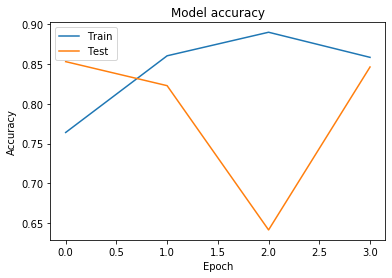

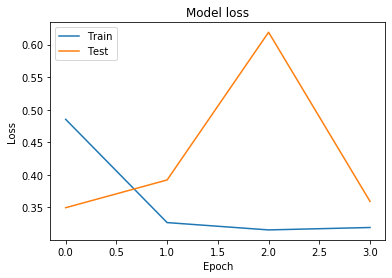

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
network.evaluate(X_test, y_test, verbose=False)

[0.3593057056903839, 0.84616]

## Задание 3.
Используйте индексы слов и их различное внутреннее представление (word2vec, glove). Как влияет данное преобразование на качество классификации?

In [18]:
# Скачиваем и расспаковываем http://nlp.stanford.edu/data/glove.840B.300d.zip

In [19]:
def load_embeddings(filename):
    embeddings_index = {}

    with open(filename, 'r') as in_file:
        for line in in_file:
            values = line.split()

            try:
                word = values[0]
                embeddings_index[word] = np.asarray(values[1:], dtype=np.float32)
            except:
                pass

    return embeddings_index


def get_embedding_matrix(embedding, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, 300))
    
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)

    return weight_matrix


embedding = load_embeddings('glove.840B.300d.txt')
weight_matrix = get_embedding_matrix(embedding, tokenizer.word_index)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional


vocab_size = len(tokenizer.word_index) + 1

network = Sequential([
    Embedding(vocab_size, 300, weights=[weight_matrix], trainable=False),
    LSTM(300),
    Dense(1, activation='sigmoid')
])

network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         28131600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 28,853,101
Trainable params: 721,501
Non-trainable params: 28,131,600
_________________________________________________________________


In [21]:
network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = network.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, batch_size=64)

Train on 20000 samples, validate on 25000 samples
Epoch 1/4
20000/20000 [==============================] - 139s 7ms/sample - loss: nan - accuracy: 0.4992 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/4
20000/20000 [==============================] - 140s 7ms/sample - loss: nan - accuracy: 0.4992 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/4
20000/20000 [==============================] - 140s 7ms/sample - loss: nan - accuracy: 0.4992 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/4
20000/20000 [==============================] - 140s 7ms/sample - loss: nan - accuracy: 0.4992 - val_loss: nan - val_accuracy: 0.5000


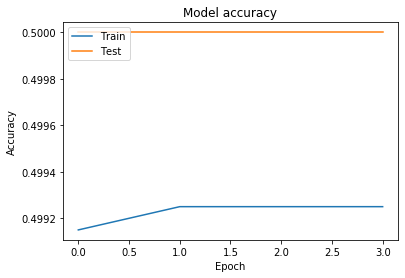

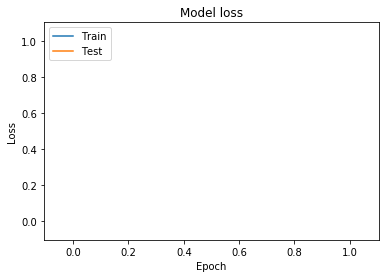

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Задание 4.
Поэкспериментируйте со структурой сети (добавьте больше рекуррентных, полносвязных или сверточных слоев). Как это повлияло на качество классификации?


In [30]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout

embedding_vecor_length = 32

network = Sequential([
    Embedding(10000, embedding_vector_length, input_length=X_train.shape[1]),
    Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 2176, 32)          320000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2176, 32)          3104      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1088, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1088, 32)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
________________________________________________

In [34]:
network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = network.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=64)

Train on 20000 samples, validate on 25000 samples
Epoch 1/2
20000/20000 [==============================] - 289s 14ms/sample - loss: 0.1973 - accuracy: 0.9247 - val_loss: 0.3684 - val_accuracy: 0.8555
Epoch 2/2
20000/20000 [==============================] - 288s 14ms/sample - loss: 0.1535 - accuracy: 0.9444 - val_loss: 0.3884 - val_accuracy: 0.8606


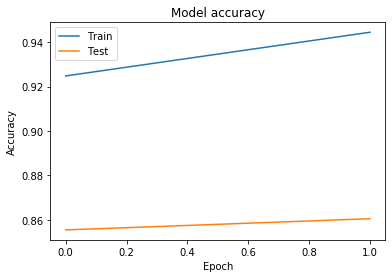

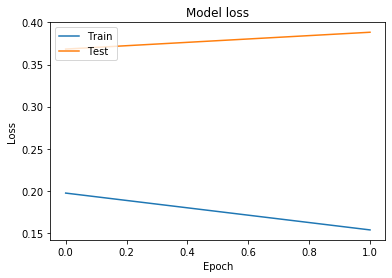

In [35]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [36]:
network.evaluate(X_test, y_test, verbose=0)

[0.3883777611231804, 0.86056]

## Задание 5.
Используйте предобученную рекуррентную нейронную сеть (например, DeepMoji или что-то подобное).